<small><i>This notebook was put together by Jake VanderPlas for UW's [Astro 599](http://www.astro.washington.edu/users/vanderplas/Astr599_2014/) course. Source and license info is on [GitHub](https://github.com/jakevdp/2014_fall_ASTR599/).</i></small>

# Optimization and Minimization

*adapted from material by Andrew Becker*

Today we're going to go over several methods for **fitting a model to data**.

## Straight-line Fit

A classic example of this is finding a "line of best fit": that is, given some data $\{x_i, y_i\}$, find a best-fit line defined by the slope $m$ and the intercept $b$. Below we'll think more generally about model fitting and show some means of doing model fitting in Python.

We'll present some of the formalism (you can read about the statistical details elsewhere), and show how to approach this in Python.

Let's create some fake data to try this out:

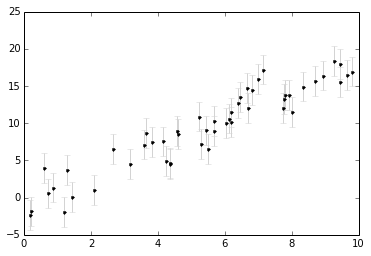

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 50
m_true = 2
b_true = -1
dy = 2.0

np.random.seed(0)
xdata = 10 * np.random.random(N)
ydata = np.random.normal(b_true + m_true * xdata, dy)

plt.errorbar(xdata, ydata, dy,
             fmt='.k', ecolor='lightgray');

For our straight-line, the model is given by

$$
y_{model}(x) = mx + b
$$

Given this model, we can define some metric of "goodness of fit". One commonly used metric is the $\chi^2$, defined as follows:

$$
\chi^2 = \sum_{i=1}^N \left(\frac{y_i - y_{model}(x)}{\sigma_y}\right)^2
$$

(Note that if you're used to thinking in terms of likelihood, the likelihood here is $\mathcal{L}\propto e^{-\chi^2}$)
Given this, our task is to minimize the $\chi^2$ with respect to the model parameters $\theta = [m, b]$ in order to find the best fit.

### Method 1: using ``scipy.optimize.fmin``

The ``scipy.optimize`` package has many optimization routines which are useful in a variety of situations:

In [2]:
from scipy import optimize
optimize?

The simplest go-to method is ``optimize.fmin``, which minimizes any given function

In [3]:
optimize.fmin?

We'll start by defining a function for our $\chi^2$:

In [4]:
def chi2(theta, x, y, dy):
    # theta = [b, m]
    return np.sum(((y - theta[0] - theta[1] * x) / dy) ** 2)

Next we call ``fmin`` to optimize this function. We need to give an initial guess for $\theta$:

In [5]:
theta_guess = [0, 1]
theta_best = optimize.fmin(chi2, theta_guess, args=(xdata, ydata, dy))
print(theta_best)

Optimization terminated successfully.
         Current function value: 42.776378
         Iterations: 70
         Function evaluations: 129
[-1.01441373  1.93854462]


Now let's plot our data and error:

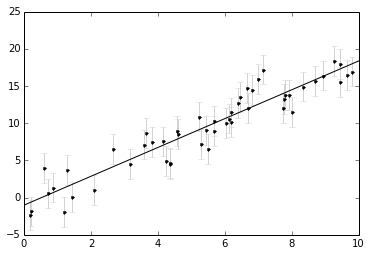

In [6]:
xfit = np.linspace(0, 10)
yfit = theta_best[0] + theta_best[1] * xfit

plt.errorbar(xdata, ydata, dy,
             fmt='.k', ecolor='lightgray');
plt.plot(xfit, yfit, '-k');

Now you can see that we've found a best-fit line for our data!

### Method 2: Least Squares Fitting

The function we used above, ``scipy.optimize.fmin``, is a general function which works for (nearly) any cost function.
Above we've used it for a linear model; it turns out that there are much simpler ways to find results for a linear model. One of these is ``scipy.optimize.leastsq``:

In [7]:
optimize.leastsq?

Here rather than computing the $\chi^2$, we compute an array of deviations from the model:

In [8]:
def deviations(theta, x, y, dy):
    return (y - theta[0] - theta[1] * x) / dy

theta_best, ier = optimize.leastsq(deviations, theta_guess, args=(xdata, ydata, dy))
print(theta_best)

[-1.01442016  1.93854659]


Again, we can plot the result:

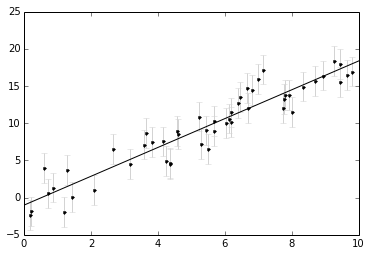

In [9]:
yfit = theta_best[0] + theta_best[1] * xfit

plt.errorbar(xdata, ydata, dy,
             fmt='.k', ecolor='lightgray');
plt.plot(xfit, yfit, '-k');

The nice thing about least squares fitting is that it includes a means of estimating the error on the fit parameters, which we can find by setting the argument ``full_output=True``

In [10]:
results = optimize.leastsq(deviations, theta_guess,
                           args=(xdata, ydata, dy),
                           full_output=True)
theta_best = results[0]
covariance = results[1]

print(covariance)

[[ 0.39232876 -0.05805744]
 [-0.05805744  0.01079204]]


This gives the uncertainty covariance of the parameters; here we see that they are nearly uncorrelated (the off-diagonal terms are close to zero) so we can approximate the fit as follows:

In [11]:
print("y = ({0:.2f} +/- {1:.2f})x + ({2:.2f} +/- {3:.2f})"
      "".format(theta_best[1], np.sqrt(covariance[1, 1]),
                theta_best[0], np.sqrt(covariance[0, 0])))

y = (1.94 +/- 0.10)x + (-1.01 +/- 0.63)


Apparently the slope is much less certain than the intercept.

### Method 3: Linear Algebra

Getting even more specialized, for a linear equation like the one above, it is possible to solve for the slope and intercept via a straightforward linear algebraic operation. For the case where all errors $dy$ are the same, we simply construct matrices

$$
X = \left[
\begin{array}{lllll}
1&1&1&\cdots&1\\
x_1&x_2&x_3&\cdots&x_N
\end{array}
\right]^T
$$

$$
y = [y_1, y_2, y_3, \cdots y_N]^T
$$

We want to solve the linear equation

$$
y = X\theta
$$

for the optimal $\theta$. We can solve this equation using either ``np.linalg.solve`` (for well-determined, full-rank problems) or ``np.linalg.lstsq`` (for under-determined problems)

In [12]:
np.linalg.solve?

In [13]:
np.linalg.lstsq?

In [14]:
Xdata = np.vstack([np.ones_like(xdata), xdata]).T
theta_best, resid, rank, singvals = np.linalg.lstsq(Xdata, ydata)
print(theta_best)

[-1.01442017  1.93854659]


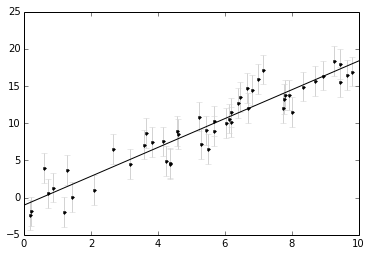

In [15]:
yfit = theta_best[0] + theta_best[1] * xfit

plt.errorbar(xdata, ydata, dy,
             fmt='.k', ecolor='lightgray');
plt.plot(xfit, yfit, '-k');

It is also possible to construct appropriate $X$ and $y$ matrices for the case when the errors are not the same; that construction can be found in many introductory texts.

As a side note, you should realize that ``np.linalg.lstsq`` is essentially just a wrapper around some simple matrix operations; we can do them ourselves as follows:

In [16]:
# compute the least-squares solution by-hand!
theta_best = np.linalg.solve(np.dot(Xdata.T, Xdata),
                             np.dot(Xdata.T, ydata))

covariance = dy ** 2 * np.linalg.inv(np.dot(Xdata.T, Xdata))

print("y = ({0:.2f} +/- {1:.2f})x + ({2:.2f} +/- {3:.2f})"
      "".format(theta_best[1], np.sqrt(covariance[1, 1]),
                theta_best[0], np.sqrt(covariance[0, 0])))

y = (1.94 +/- 0.10)x + (-1.01 +/- 0.63)


Notice that this is the same result we got above.
You can consult an intro statistics book to see where these expressions come from.

### Optimization in Python: Summary

- For *general* optimization problems, you can use ``scipy.optimize.fmin``.

- For *least-squares* optimization problems, you can use ``scipy.optimize.leastsq``.

- For *linear least-squares* optimization problems, you can use ``np.linalg.lstsq``, or you can go through the formalism and compute the result via standard linear algebraic operations.

## A Note on Model Complexity

How do you know what model to fit to data? Note that as your model gets more and more complex, you can do a better and better job fitting the data.

For example, rather than a linear model we could use

$$
y = \theta_0 + \theta_1 x + \theta_2 x^2
$$

Let's use ``np.polyfit`` to fit this model to our data:

In [17]:
def fit_polynomial(deg=2):
    p = np.polyfit(xdata, ydata, deg=deg)
    yfit = np.polyval(p, xfit)
    plt.errorbar(xdata, ydata, dy,
                 fmt='.k', ecolor='lightgray');
    plt.plot(xfit, yfit);
    rms = np.sqrt(np.mean((ydata - np.polyval(p, xdata)) ** 2))
    print("rms error (deg={0}): {1:.2f}".format(deg, rms))                                        

rms error (deg=2): 1.84


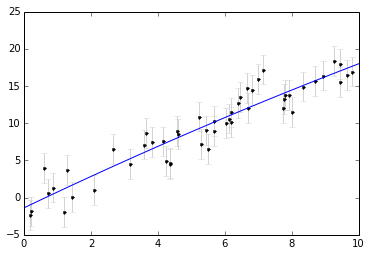

In [18]:
fit_polynomial(2)

As a rule, when we increase the degree of the polynomial, we get a better fit!

rms error (deg=10): 1.49


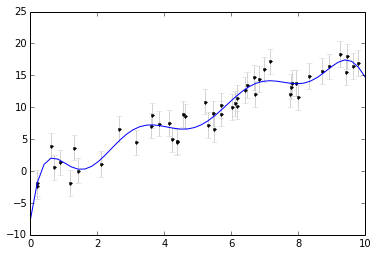

In [19]:
fit_polynomial(10)

But is this actually a better fit? There are well-understood ways to determine this.

### How do you know when to stop?

As you add more complexity to the model, the goodness of fit will **always** improve (unless your code has a bug, and until $\chi^2=0$).  The rule of thumb is that the number of terms you add should be far greater than the improvement in $\chi^2$.  

For more statistical rigor (Numerical Recipes section 15.6), when adding N parameters to a model, $\Delta \chi^2_N$ it distrubted as a $\chi^2$ distribution with N degrees of freedom.  Below we outline $\Delta \chi^2_N$ as a function of confidence level and N:
<table>
<tr> <th> p </th> <th> N=1 </th> <th> N=2 </th> <th> N=3 </th> </tr>
<tr> <th> 68.3% </th> <th> $\Delta \chi^2$ = 1.00 </th> <th> $\Delta \chi^2$ = 2.30 </th> <th> $\Delta \chi^2$ = 3.53 </th> </tr>
<tr> <th> 95.4% </th> <th> $\Delta \chi^2$ = 4.00 </th> <th> $\Delta \chi^2$ = 6.17 </th> <th> $\Delta \chi^2$ = 8.02 </th> </tr>
<tr> <th> 99.73% </th> <th> $\Delta \chi^2$ = 9.00 </th> <th> $\Delta \chi^2$ = 11.8 </th> <th> $\Delta \chi^2$ = 14.2 </th> </tr>
</table>


### How do you know when you've gone too far?

"Overfitting" is a common problem in model selection.  You typically want a "parsimonious" model that captures the important information using a small number of parameters.  This model is frequently selected by looking at the *bias* vs. *variance* trade-off.

Bias = < data - model >

Variance = < (data - model)$^2$ >

<div class="image-content">    
    <table class="snug">
        <tbody><tr>
            <th></th>
            <td>
                Low Variance
            </td>
            <td>
                High Variance
            </td>
        </tr>
        <tr>
            <td class="r90">
                Low Bias
            </td>
            <td>
                <div id="bullsEyeLBLV"><svg style="border: medium none;" height="200" width="200"><circle style="fill: white;" r="90.9090909090909" cy="100" cx="100" class="ring"></circle><circle style="fill: rgb(118, 179, 216);" r="62.5" cy="100" cx="100" class="ring"></circle><circle style="fill: white;" r="36.36363636363637" cy="100" cx="100" class="ring"></circle><circle style="fill: rgb(193, 47, 62);" r="13.333333333333334" cy="100" cx="100" class="ring"></circle><circle r="2.5" cy="98.78231506348611" cx="95.2417299219265" class="arrow"></circle><circle r="2.5" cy="98.35369950854978" cx="94.98877477792978" class="arrow"></circle><circle r="2.5" cy="90.1611985381718" cx="98.64499086445454" class="arrow"></circle><circle r="2.5" cy="103.46102989370513" cx="98.29842135491629" class="arrow"></circle><circle r="2.5" cy="100.68784532768193" cx="95.79393665077546" class="arrow"></circle><circle r="2.5" cy="101.81130596018545" cx="99.98795100308158" class="arrow"></circle><circle r="2.5" cy="96.3757227502656" cx="89.34113757239132" class="arrow"></circle><circle r="2.5" cy="93.85728904385391" cx="92.93663382940163" class="arrow"></circle><circle r="2.5" cy="92.74432495644449" cx="91.27400877365645" class="arrow"></circle><circle r="2.5" cy="90.25639751501993" cx="98.35171143651966" class="arrow"></circle><circle r="2.5" cy="89.80271518867866" cx="89.84479267773501" class="arrow"></circle><circle r="2.5" cy="102.31429122988574" cx="102.92811906669978" class="arrow"></circle><circle r="2.5" cy="94.33502755999424" cx="98.43292822053172" class="arrow"></circle><circle r="2.5" cy="88.32650985799843" cx="100.03977392090455" class="arrow"></circle><circle r="2.5" cy="91.38063914598084" cx="90.45638062240717" class="arrow"></circle><circle r="2.5" cy="105.83526025811605" cx="91.814500886036" class="arrow"></circle><circle r="2.5" cy="94.63423346645308" cx="93.48689316677351" class="arrow"></circle><circle r="2.5" cy="98.98875335330786" cx="93.2603587976381" class="arrow"></circle><circle r="2.5" cy="92.17361145704697" cx="96.46568926721694" class="arrow"></circle><circle r="2.5" cy="88.55473443715668" cx="91.90571922505733" class="arrow"></circle><circle r="2.5" cy="96.86760959426755" cx="103.20972223139" class="arrow"></circle><circle r="2.5" cy="102.46241789283684" cx="90.45135687581899" class="arrow"></circle><circle r="2.5" cy="109.14141342737429" cx="96.83775784414765" class="arrow"></circle><circle r="2.5" cy="102.33783592020343" cx="88.47009267490499" class="arrow"></circle><circle r="2.5" cy="99.25599334201341" cx="103.08969765418682" class="arrow"></circle></svg></div>
            </td>
            <td>
                <div id="bullsEyeLBHV"><svg style="border: medium none;" height="200" width="200"><circle style="fill: white;" r="90.9090909090909" cy="100" cx="100" class="ring"></circle><circle style="fill: rgb(118, 179, 216);" r="62.5" cy="100" cx="100" class="ring"></circle><circle style="fill: white;" r="36.36363636363637" cy="100" cx="100" class="ring"></circle><circle style="fill: rgb(193, 47, 62);" r="13.333333333333334" cy="100" cx="100" class="ring"></circle><circle r="2.5" cy="109.53667975411805" cx="135.30208525468566" class="arrow"></circle><circle r="2.5" cy="73.55338417474053" cx="128.43144410223016" class="arrow"></circle><circle r="2.5" cy="115.09033226489368" cx="62.46329544014869" class="arrow"></circle><circle r="2.5" cy="66.14548779266283" cx="126.27343247249648" class="arrow"></circle><circle r="2.5" cy="96.79804569434428" cx="87.5311440807998" class="arrow"></circle><circle r="2.5" cy="73.31114567408036" cx="89.86553587619488" class="arrow"></circle><circle r="2.5" cy="71.56278538776868" cx="72.14224642068129" class="arrow"></circle><circle r="2.5" cy="99.4197165637036" cx="133.67943947732815" class="arrow"></circle><circle r="2.5" cy="118.7690125167322" cx="95.39079143636448" class="arrow"></circle><circle r="2.5" cy="89.90155532250407" cx="94.97114920044513" class="arrow"></circle><circle r="2.5" cy="104.44717591002323" cx="97.76397547830885" class="arrow"></circle><circle r="2.5" cy="85.24513430882038" cx="89.30844911697717" class="arrow"></circle><circle r="2.5" cy="110.46435847056802" cx="84.9656556483016" class="arrow"></circle><circle r="2.5" cy="111.22511714783076" cx="94.47025121828862" class="arrow"></circle><circle r="2.5" cy="87.45496868419164" cx="81.19000260405745" class="arrow"></circle><circle r="2.5" cy="109.70597207613788" cx="52.31412324140461" class="arrow"></circle><circle r="2.5" cy="121.38043888867571" cx="84.07493934147824" class="arrow"></circle><circle r="2.5" cy="96.32433545651551" cx="79.96730411760538" class="arrow"></circle><circle r="2.5" cy="104.32403135668825" cx="97.5698900562818" class="arrow"></circle><circle r="2.5" cy="102.24003307409187" cx="64.83727832847151" class="arrow"></circle><circle r="2.5" cy="111.54952202719106" cx="96.43564661227427" class="arrow"></circle><circle r="2.5" cy="118.67825786463287" cx="113.09578479104827" class="arrow"></circle><circle r="2.5" cy="107.66971927290987" cx="103.04118268265579" class="arrow"></circle><circle r="2.5" cy="128.31617509558063" cx="76.27875910415312" class="arrow"></circle><circle r="2.5" cy="95.5293181876095" cx="129.12754678814048" class="arrow"></circle></svg></div>
            </td>
        </tr>
        <tr>
            <td class="r90">
                High Bias
            </td>
            <td>
                <div id="bullsEyeHBLV"><svg style="border: medium none;" height="200" width="200"><circle style="fill: white;" r="90.9090909090909" cy="100" cx="100" class="ring"></circle><circle style="fill: rgb(118, 179, 216);" r="62.5" cy="100" cx="100" class="ring"></circle><circle style="fill: white;" r="36.36363636363637" cy="100" cx="100" class="ring"></circle><circle style="fill: rgb(193, 47, 62);" r="13.333333333333334" cy="100" cx="100" class="ring"></circle><circle r="2.5" cy="42.328637258595556" cx="93.27374996049726" class="arrow"></circle><circle r="2.5" cy="44.93556686811315" cx="105.52581398889991" class="arrow"></circle><circle r="2.5" cy="46.7755302240622" cx="95.26101246647794" class="arrow"></circle><circle r="2.5" cy="52.86933183374843" cx="112.05060873387474" class="arrow"></circle><circle r="2.5" cy="57.67330743618805" cx="110.17742629325286" class="arrow"></circle><circle r="2.5" cy="47.63329341720682" cx="102.62633835599787" class="arrow"></circle><circle r="2.5" cy="53.86880949845978" cx="104.97396150323235" class="arrow"></circle><circle r="2.5" cy="48.3116835441338" cx="103.76256282114713" class="arrow"></circle><circle r="2.5" cy="48.05373982750756" cx="97.84406081280112" class="arrow"></circle><circle r="2.5" cy="60.8819662990806" cx="105.47413674536088" class="arrow"></circle><circle r="2.5" cy="50.42653499700785" cx="101.32433258243718" class="arrow"></circle><circle r="2.5" cy="53.5123837318865" cx="107.75895816267607" class="arrow"></circle><circle r="2.5" cy="43.22134477028904" cx="102.34151233023265" class="arrow"></circle><circle r="2.5" cy="48.99085752653546" cx="102.74836927714325" class="arrow"></circle><circle r="2.5" cy="50.700765047971295" cx="103.5514955929248" class="arrow"></circle><circle r="2.5" cy="52.960882058099266" cx="99.66489163788832" class="arrow"></circle><circle r="2.5" cy="50.56365067938392" cx="104.03334679960989" class="arrow"></circle><circle r="2.5" cy="51.05603578517508" cx="112.40294162147084" class="arrow"></circle><circle r="2.5" cy="48.69041724555987" cx="103.77185736249525" class="arrow"></circle><circle r="2.5" cy="52.16305294199713" cx="105.75923213844915" class="arrow"></circle><circle r="2.5" cy="45.76240834088125" cx="100.02620538056256" class="arrow"></circle><circle r="2.5" cy="49.1548990106344" cx="92.6900668670068" class="arrow"></circle><circle r="2.5" cy="54.66889873214721" cx="102.52276709795272" class="arrow"></circle><circle r="2.5" cy="54.816287121818064" cx="92.63240239912123" class="arrow"></circle><circle r="2.5" cy="44.1308081872826" cx="93.67433387840616" class="arrow"></circle></svg></div>
            </td>
            <td>
                <div id="bullsEyeHBHV"><svg style="border: medium none;" height="200" width="200"><circle style="fill: white;" r="90.9090909090909" cy="100" cx="100" class="ring"></circle><circle style="fill: rgb(118, 179, 216);" r="62.5" cy="100" cx="100" class="ring"></circle><circle style="fill: white;" r="36.36363636363637" cy="100" cx="100" class="ring"></circle><circle style="fill: rgb(193, 47, 62);" r="13.333333333333334" cy="100" cx="100" class="ring"></circle><circle r="2.5" cy="35.245951954634805" cx="103.71226190486529" class="arrow"></circle><circle r="2.5" cy="67.2447331281883" cx="85.66758527040301" class="arrow"></circle><circle r="2.5" cy="32.140931024292215" cx="62.28568550397415" class="arrow"></circle><circle r="2.5" cy="27.594136705300244" cx="44.453050499204494" class="arrow"></circle><circle r="2.5" cy="34.97572973546029" cx="65.5267486415562" class="arrow"></circle><circle r="2.5" cy="63.901284157820186" cx="52.31696098385054" class="arrow"></circle><circle r="2.5" cy="18.83190221128146" cx="48.16744830325244" class="arrow"></circle><circle r="2.5" cy="45.429332524802895" cx="74.76574746979051" class="arrow"></circle><circle r="2.5" cy="10.626913149263643" cx="93.43125456438462" class="arrow"></circle><circle r="2.5" cy="46.07543950204163" cx="68.5906869780192" class="arrow"></circle><circle r="2.5" cy="37.09650785588681" cx="76.78805778650607" class="arrow"></circle><circle r="2.5" cy="50.971128326292146" cx="72.76655176927713" class="arrow"></circle><circle r="2.5" cy="61.927273912222816" cx="42.724353763919886" class="arrow"></circle><circle r="2.5" cy="39.15213297199204" cx="112.20625419743854" class="arrow"></circle><circle r="2.5" cy="38.854779509806455" cx="88.36900320964696" class="arrow"></circle><circle r="2.5" cy="56.46641986123598" cx="63.66053914630819" class="arrow"></circle><circle r="2.5" cy="43.16404842444755" cx="68.96191500872605" class="arrow"></circle><circle r="2.5" cy="28.74648178852344" cx="35.635519046608465" class="arrow"></circle><circle r="2.5" cy="59.740609767146466" cx="68.60182810836173" class="arrow"></circle><circle r="2.5" cy="25.547080430710736" cx="95.5153403974868" class="arrow"></circle><circle r="2.5" cy="19.62606830684345" cx="46.37075852226722" class="arrow"></circle><circle r="2.5" cy="50.71556277512999" cx="89.9950666768221" class="arrow"></circle><circle r="2.5" cy="42.52949470919935" cx="64.45958584171213" class="arrow"></circle><circle r="2.5" cy="4.197361489016814" cx="95.57718864645554" class="arrow"></circle><circle r="2.5" cy="32.127872854044625" cx="70.63354751617322" class="arrow"></circle></svg></div>
            </td>
        </tr>
    </tbody></table>
</div><div class="caption">Graphical illustration of bias and variance (http://scott.fortmann-roe.com)</div>

When determining model complexity, there are other metrics to use than $\Delta \chi^2$, especially when comparing different clases of models.  E.g. mean squared error: 

MSE = bias$^2$ + variance

<img src="files/images/biasvariance.png"/>

*<small>http://scott.fortmann-roe.com</small>*

There are principled methods that help you decide the order of your models by adding a **penalty** to the calculation of $\chi^2$.  These include the Bayesian Information Criterion (BIC) or Akaike Information Criterion (AIC):

BIC = $\chi^2$ + *Nterm* $\cdot$ ln(*Ndata*)

AIC = $\chi^2$ + *Nterm* $\cdot$ 2 

## Real World Example: Fourier Series Fit

As an example, we will fit a Fourier series to a folded periodic variable star lightcurve from the LINEAR survey.

The code below requires the [astroML](http://www.astroML.org) package, which you can easily install by running

```
$ pip install astroML
```

We will examine how $\chi^2$, BIC, and AIC vary as we change the number of terms in the Fourier series.  If we do not get through this whole exercise, your homework will be to finish the notebook, and then repeat the analysis for another variable star from the data.  I would like to see as a function of the number of terms in your analysis: $\chi^2$, $\Delta \chi^2$ compared to the previous model, the significance of $\Delta \chi^2$, AIC, and BIC.  Indicate the order of the series you would choose based on each of the above numbers (they may be different for $\Delta \chi^2$, AIC, and BIC).

In [20]:
# Uncomment and run this to install astroML
# !pip install astroML
# !pip install astroML_addons

In [21]:
%matplotlib inline
import astroML.datasets
import numpy as np
import matplotlib.pyplot as plt

In [22]:
lcs = astroML.datasets.fetch_LINEAR_sample()

In [23]:
print lcs

In [24]:
time, flux, dflux = lcs[18525697].T

Plot the raw lightcurve

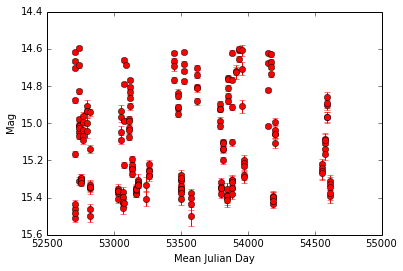

In [25]:
plt.errorbar(time, flux, yerr=dflux, fmt="ro")
plt.gca().invert_yaxis()
plt.xlabel("Mean Julian Day")
plt.ylabel("Mag")
plt.show()

In this case, we know its a periodic variable star.  The whole issue of *if* an object is periodic is the subject of a whole other lecture.  In this case, we take it as fact, and attempt to find the optimal period by using a Lomb Scargle analysis (itself the subject of another lecture entirely).

The periodogram is essentially a normalized inverse $\chi^2$, so that the maximum of the periodogram corresponds to the best-fit Fourier series.

In [26]:
from astroML.time_series import lomb_scargle
periods = np.logspace(-1, 0, 10000, base=10)
periodogram = lomb_scargle(time, flux, dflux, omega=2 * np.pi / periods, generalized=True)

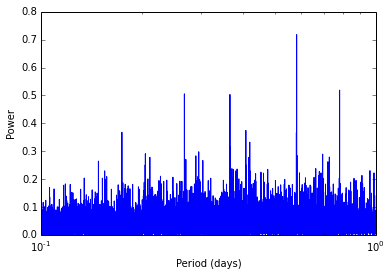

In [27]:
plt.plot(periods, periodogram)
plt.semilogx()
plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.show()

Find the peak of this periodogram using ``argmax``

In [28]:
idx = np.argmax(periodogram)

print periods[idx], periodogram[idx]

0.580331798284 0.717932373858


Now "fold" the lightcurve at this best period.  By "folding" I mean find the phase at which the star is in its oscillation (phase is defined here as running from 0 to 1), for every data point.  This is the MJD / period (e.g. 81761.7165) minus the integer portion of this value MJD // period (e.g. 81761) = 0.7165.

In [30]:
period = periods[idx]
phase = time / period - time // period 
print min(phase), max(phase)

0.00166719715344 0.999931284314


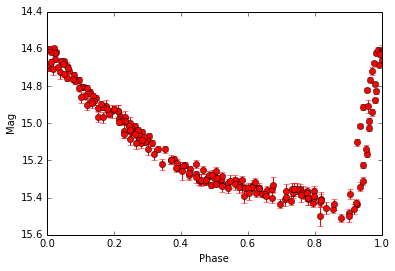

In [31]:
plt.errorbar(phase, flux, yerr=dflux, fmt="ro")
plt.gca().invert_yaxis()
plt.xlabel("Phase")
plt.ylabel("Mag")
plt.show()

Now we need to get serious.  We want a function we can call to return $\chi^2$ for a model fit.  It makes a lot of sense to have this be a method on a class.  Then the class can contain the data it is fitting as member variables (e.g. self.flux).  We also want an evaluate() method that returns the lightcurve for a given set of phases, so that we can plot it.  Design a very basic class to do this.  The lightcurve model that this class will fit to the data is of the form:

$$
Model = A_0 + A_1 * \cos(2 \pi\cdot phase + \phi_1) + A_2 * \cos(2 \pi\cdot phase + \phi_2) + \cdots + A_N * \cos(2 \pi N \cdot phase + \phi_N)
$$

with model parameters [ A$_0$ A$_1$ $\phi_1$ A$_2$ $\phi_2$ ... A$_N$ $\phi_N$ ]

Let's create a class that implements this model:

In [32]:
class Fourier(object):
    def __init__(self, phase, flux, dflux, nterms):
        self.phase = phase
        self.flux = flux
        self.dflux = dflux
        self.nterms = nterms
        assert(self.nterms > 0)
        
    def evaluate(self, phase, terms):
        assert(len(terms) == 2 * self.nterms - 1)
        model = terms[0] * np.ones(len(phase))
        for i in range(self.nterms-1):
            model += terms[2*i + 1] * np.cos(2 * np.pi * (i+1) * phase + terms[2*i + 2])
        return model
    
    def chi2(self, args):
        model = self.evaluate(self.phase, args)
        chi   = (model - self.flux) / self.dflux
        return np.sum(chi**2)

In [33]:
fourier = Fourier(phase, flux, dflux, 1)
mphase = np.arange(0, 1, 0.01)
model = fourier.evaluate(mphase, [10])

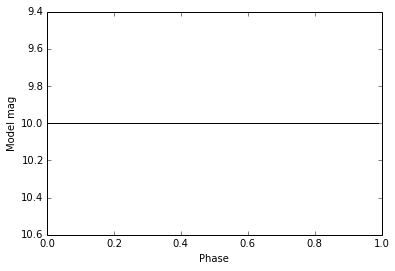

In [34]:
plt.plot(mphase, model, "k-")
plt.gca().invert_yaxis()
plt.xlabel("Phase")
plt.ylabel("Model mag")
plt.show()

Now for a more interesting model, with some actual values:

In [35]:
fourier = Fourier(phase, flux, dflux, 2)
mphase = np.arange(0, 1, 0.01)
model = fourier.evaluate(mphase, [10, 0.1, 0.0])

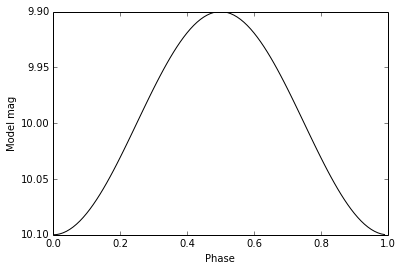

In [36]:
plt.plot(mphase, model, "k-")
plt.gca().invert_yaxis()
plt.xlabel("Phase")
plt.ylabel("Model mag")
plt.show()

Let's check what this looks like if we change the phase:

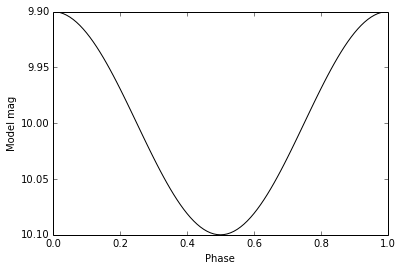

In [37]:
fourier = Fourier(phase, flux, dflux, 2)
mphase = np.arange(0, 1, 0.01)
model = fourier.evaluate(mphase, [10, 0.1, np.pi])

plt.plot(mphase, model, "k-")
plt.gca().invert_yaxis()
plt.xlabel("Phase")
plt.ylabel("Model mag")
plt.show()

Since we have a complicated model, let's use ``optimize.fmin``, as we did above.
We'll fit a 2 term model to the data (1 constant term, and 1 term with an amplitude and phase offset)

In [38]:
fourier = Fourier(phase, flux, dflux, 2)
guess   = [] # this needs to be the number of paramters you want to fit for, here the mean brightness, the amplitude, and minimum
guess.append(np.mean(fourier.flux))
guess.append(np.std(fourier.flux))

We'll initialize the phase with the phase of the minimum flux

In [39]:
print(np.argmax(fourier.flux))

6


In [40]:
print(fourier.flux[np.argmax(fourier.flux)])

15.509


In [41]:
print(fourier.phase[np.argmax(fourier.flux)])

0.879930489682


In [42]:
guess.append(2 * np.pi * (1 - fourier.phase[np.argmax(fourier.flux)]))

Finally, we have our initial guess:

In [43]:
print(guess)

[15.101739336492891, 0.26149871243334849, 0.75441898307024013]


Make it so!

In [44]:
optimize.fmin(fourier.chi2, x0=[guess], disp=0, full_output=1)

(array([ 15.1035305 ,  -0.34102511,  -0.49636256]),
 13332.31542512862,
 120,
 209,
 0)

Capture the output and look at the "best fit" parameters.  I.e. those that minimized the return value of fourier.chi2.

In [45]:
result = optimize.fmin(fourier.chi2, x0=[guess], disp=0, full_output=1)
best_fit = result[0]
print(best_fit)

[ 15.1035305   -0.34102511  -0.49636256]


Plot the model up, compared to the data and the initial guess

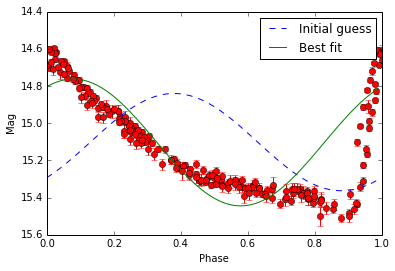

In [46]:
plt.errorbar(fourier.phase, fourier.flux, yerr=fourier.dflux, fmt="ro")
plt.plot(mphase, fourier.evaluate(mphase, guess), "b--", label="Initial guess")
plt.plot(mphase, fourier.evaluate(mphase, best_fit), "g-", label="Best fit")
plt.gca().invert_yaxis()
plt.xlabel("Phase")
plt.ylabel("Mag")
plt.legend()
plt.show()

Looks "eh".  What is the goodness of fit of the model?  The reduced chi2 (i.e. chi2 per degree of freedom) gives an absolute "goodness of fit" to your model: you expect this to be a value near 1.0:

$$
\chi^2_\nu = \frac{\chi2}{Npts - Nterms - 1}
$$

In [47]:
chi2_1 = result[1]
chi2_2 = fourier.chi2(best_fit)
print chi2_1, chi2_2, chi2_1 / (len(flux) - len(best_fit) - 1)

13332.3154251 13332.3154251 64.4073208943


In [48]:
fourier2 = Fourier(phase, flux, dflux, 3)
guess2   = [] # this needs to be the number of paramters you want to fit for, now 2*3-1 = 5
guess2.append(np.mean(fourier2.flux))
guess2.append(np.std(fourier2.flux))
guess2.append(2 * np.pi * (1 - fourier2.phase[np.argsort(fourier2.flux)[-1]]))
guess2.append(0.0)
guess2.append(2 * np.pi * (1 - fourier2.phase[np.argsort(fourier2.flux)[-1]]))
result2 = optimize.fmin_bfgs(fourier2.chi2, x0=[guess2], disp=0, full_output=1)
best_fit2 = result2[0]
print best_fit2

[ 15.13830456  -0.32363282  -0.72001082  -0.15249286  -0.48308296]


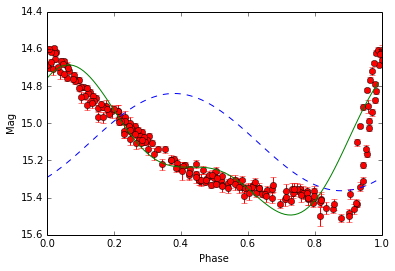

In [49]:
plt.errorbar(fourier2.phase, fourier2.flux, yerr=fourier2.dflux, fmt="ro")
plt.plot(mphase, fourier2.evaluate(mphase, guess2), "b--", label="Initial guess")
plt.plot(mphase, fourier2.evaluate(mphase, best_fit2), "g-", label="Best fit")
plt.gca().invert_yaxis()
plt.xlabel("Phase")
plt.ylabel("Mag")
plt.show()

More cowbell!

In [50]:
fourier5 = Fourier(phase, flux, dflux, 5)
guess5   = [] # this needs to be the number of paramters you want to fit for, now 9
guess5.append(np.mean(fourier5.flux))
guess5.append(np.std(fourier5.flux))
guess5.append(2 * np.pi * (1 - fourier5.phase[np.argsort(fourier5.flux)[-1]]))
for i in range(2, 5):
    guess5.append(0.0)
    guess5.append(2 * np.pi * (1 - fourier5.phase[np.argsort(fourier5.flux)[-1]]))
result5 = optimize.fmin_bfgs(fourier5.chi2, x0=[guess5], disp=0, full_output=1)
best_fit5 = result5[0]
print best_fit5

[ 15.15967221  -0.29384084  -0.8412157   -0.15320473  -0.90782949
  -0.11099549  -0.44864424  -0.08383252   0.04671944]


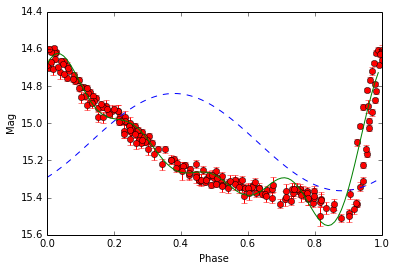

In [51]:
plt.errorbar(fourier5.phase, fourier5.flux, yerr=fourier5.dflux, fmt="ro")
plt.plot(mphase, fourier5.evaluate(mphase, guess5), "b--", label="Initial guess")
plt.plot(mphase, fourier5.evaluate(mphase, best_fit5), "g-", label="Best fit")
plt.gca().invert_yaxis()
plt.xlabel("Phase")
plt.ylabel("Mag")
plt.show()

Am getting tired of initializing "guess" all the time.  We can make a method on the class that does this for us!  Lets inherit from the main Fourier class, so that we only have to implement that method.  Part of the point of this is to demonstrate class inheritance.

In [52]:
class Fourier2(Fourier):
    def __init__(self, phase, flux, dflux, nterms):
        Fourier.__init__(self, phase, flux, dflux, nterms)
                
    def makeGuess(self):
        guess = []
        guess.append(np.mean(self.flux))
        if self.nterms > 1:
            guess.append(np.std(self.flux))
            guess.append(2 * np.pi * (1 - self.phase[np.argsort(self.flux)[-1]]))
            for i in range(2, self.nterms):
                guess.append(0.0)
                guess.append(2 * np.pi * (1 - self.phase[np.argsort(self.flux)[-1]]))
        return guess

Now that everything is pipelined, lets run this for a range of models, and plot how chi2 improves as you increase the model parameters.  Note that it will *always* decrease as you add terms!!!!  Up to a limit: the end point of this process is when you have 1 parameter for every data point, in which case your chi2 should be 0.0.

[15.101739336492891]
[15.101739336492891, 0.26149871243334849, 0.75441898307024013]
[15.101739336492891, 0.26149871243334849, 0.75441898307024013, 0.0, 0.75441898307024013]
[15.101739336492891, 0.26149871243334849, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307024013]
[15.101739336492891, 0.26149871243334849, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307024013]
[15.101739336492891, 0.26149871243334849, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307024013]
[15.101739336492891, 0.26149871243334849, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307024013]
[15.101739336492891, 0.26149871243334849, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307024013, 0.0, 0.75441898307

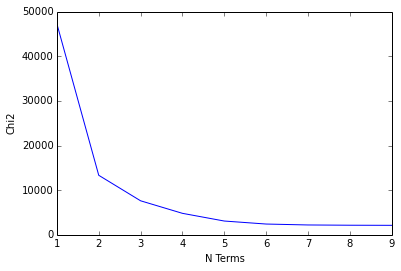

In [53]:
nterms = np.arange(1, 10)
chi2   = []
for nterm in nterms:
    fourier = Fourier2(phase, flux, dflux, nterm)
    guess = fourier.makeGuess()
    print(guess)
    chi2.append(optimize.fmin_bfgs(fourier.chi2, x0=[guess], disp=0, full_output=1)[1])
chi2 = np.array(chi2)
plt.plot(nterms, chi2)
plt.xlabel("N Terms")
plt.ylabel("Chi2")
plt.show()
    

And what is delta chi2?  Note it converges to zero, i.e. you are getting less and less improvement with the addition of every new term.  Now we have to start being careful.

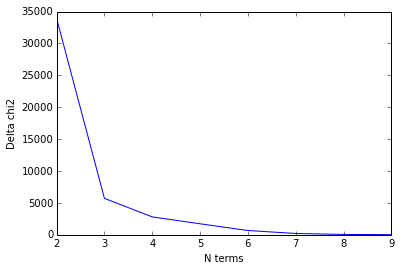

In [54]:
delta_chi2 = chi2[:-1] - chi2[1:]
plt.plot(nterms[1:], delta_chi2)
plt.xlabel("N terms")
plt.ylabel("Delta chi2")
plt.show()
# You will need to figure out the significance of all these delta_chi2 as part of your homework!

Lets start to look at the penalties imposed by BIC/AIC.

In [55]:
nterms     = np.arange(1, 10)
chi2       = []
BICpenalty = []
AICpenalty = []
for nterm in nterms:
    fourier = Fourier2(phase, flux, dflux, nterm)
    guess   = fourier.makeGuess()
    BICpenalty.append(len(guess) * np.log(len(fourier.phase)))
    AICpenalty.append(len(guess) * 2.0)
    chi2.append(optimize.fmin_bfgs(fourier.chi2, x0=[guess], disp=0, full_output=1)[1])
chi2 = np.array(chi2)
BICpenalty = np.array(BICpenalty)
AICpenalty = np.array(AICpenalty)

In [56]:
print chi2
print BICpenalty
print AICpenalty

[ 47266.37929305  13332.31540318   7618.56565643   4809.05302958
   3083.87142319   2410.26885471   2203.09437531   2144.97764373
   2121.13490158]
[  5.35185813  16.0555744   26.75929067  37.46300693  48.1667232
  58.87043947  69.57415574  80.277872    90.98158827]
[  2.   6.  10.  14.  18.  22.  26.  30.  34.]


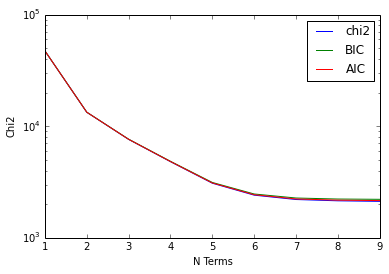

In [57]:
plt.plot(nterms, chi2, label="chi2")
plt.plot(nterms, chi2 + BICpenalty, label="BIC")
plt.plot(nterms, chi2 + AICpenalty, label="AIC")
plt.xlabel("N Terms")
plt.ylabel("Chi2")
plt.semilogy()
plt.legend()
plt.show()

Can kinda see that BIC/AIC are telling you to stop.  Lets make it more apparent.

In [58]:
nterms     = np.arange(1, 30, 2)
chi2       = []
BICpenalty = []
AICpenalty = []
for nterm in nterms:
    fourier = Fourier2(phase, flux, dflux, nterm)
    guess   = fourier.makeGuess()
    BICpenalty.append(len(guess) * np.log(len(fourier.phase)))
    AICpenalty.append(len(guess) * 2.0)
    chi2.append(optimize.fmin_bfgs(fourier.chi2, x0=[guess], disp=0, full_output=1)[1])
chi2 = np.array(chi2)
BICpenalty = np.array(BICpenalty)
AICpenalty = np.array(AICpenalty)

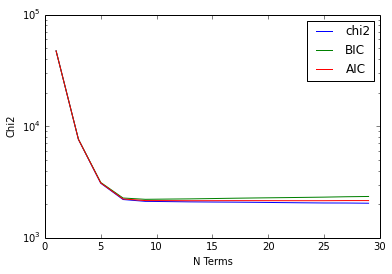

In [59]:
plt.plot(nterms, chi2, label="chi2")
plt.plot(nterms, chi2 + BICpenalty, label="BIC")
plt.plot(nterms, chi2 + AICpenalty, label="AIC")
plt.xlabel("N Terms")
plt.ylabel("Chi2")
plt.semilogy()
plt.legend()
plt.show()

Which of the fits have the minimum BIC/AIC?

In [60]:
print np.argmin(chi2+BICpenalty), np.argmin(chi2+AICpenalty)

4 6


And what order model do they suggest?

In [61]:
print nterms[4], nterms[6]

9 13


Note that these will typically be different.  And this is when you say to the referee "We examined the order of model selection using both the BIC and the AIC, and find that our conclusions are insensitive to which model is preferred.  Accordingly, we chose the most parsimonious model for our final analysis".  Because if you do find your results depend significantly on the model order at this level, you should rethink how you're doing things (e.g. is your model's functional form correct).

## Homework

Homework: repeat the exercise with a different star of your choosing. Find the order of the model that delta chi2, AIC, and BIC would suggest.
Turn in the homework again via github, using the filename ``HW3.ipynb``.